In [16]:
# Import neccessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
import holidays
import joblib

In [17]:
# Read data from csv file and make a data frame
orders = pd.read_csv("./datasets/restaurant-1-orders.csv")
orders

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6
...,...,...,...,...,...,...
74813,2518,18/05/2016 18:53,House Red wine 75cl,2,17.95,7
74814,2503,14/05/2016 19:28,House Red wine 75cl,2,17.95,6
74815,2467,10/05/2016 13:18,House Red wine 75cl,2,17.95,9
74816,2249,07/04/2016 19:04,House white wine 75cl,1,17.95,6


In [18]:
# Check NaN value of dataset
orders.isna().sum()

Order Number      0
Order Date        0
Item Name         0
Quantity          0
Product Price     0
Total products    0
dtype: int64

In [19]:
# Describe the dataset
orders.describe()

,Order Number,Quantity,Product Price,Total products
count,74818.000000,74818.000000,74818.000000,74818.000000
mean,9115.638162,1.243564,5.286492,6.931434
std,4052.210452,0.798207,3.338221,3.954832
min,630.000000,1.000000,0.500000,1.000000
25%,5590.000000,1.000000,2.950000,5.000000
50%,9103.000000,1.000000,3.950000,6.000000
75%,12630.000000,1.000000,8.950000,8.000000
max,16118.000000,51.000000,17.950000,60.000000


In [20]:
# Get the info of each column
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order Number    74818 non-null  int64  
 1   Order Date      74818 non-null  object 
 2   Item Name       74818 non-null  object 
 3   Quantity        74818 non-null  int64  
 4   Product Price   74818 non-null  float64
 5   Total products  74818 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB


In [21]:
# Convert the order date column to the datetime
orders['Order Date'] = pd.to_datetime(orders['Order Date'], dayfirst=True)
orders

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,2019-08-03 20:25:00,Plain Papadum,2,0.80,6
1,16118,2019-08-03 20:25:00,King Prawn Balti,1,12.95,6
2,16118,2019-08-03 20:25:00,Garlic Naan,1,2.95,6
3,16118,2019-08-03 20:25:00,Mushroom Rice,1,3.95,6
4,16118,2019-08-03 20:25:00,Paneer Tikka Masala,1,8.95,6
...,...,...,...,...,...,...
74813,2518,2016-05-18 18:53:00,House Red wine 75cl,2,17.95,7
74814,2503,2016-05-14 19:28:00,House Red wine 75cl,2,17.95,6
74815,2467,2016-05-10 13:18:00,House Red wine 75cl,2,17.95,9
74816,2249,2016-04-07 19:04:00,House white wine 75cl,1,17.95,6


In [22]:
# Get the total order of each date
orders_quantity_by_date = orders[['Order Date', 'Quantity']].resample('D', on='Order Date').sum().reset_index()
orders_quantity_by_date

,Order Date,Quantity
0,2015-09-01,1
1,2015-09-02,0
2,2015-09-03,0
3,2015-09-04,0
4,2015-09-05,0
...,...,...
1428,2019-07-30,100
1429,2019-07-31,87
1430,2019-08-01,65
1431,2019-08-02,132


In [23]:
# Find the min value of order date
orders_quantity_by_date['Order Date'].min()

Timestamp('2015-09-01 00:00:00')

In [24]:
# Find the max value of order date
orders_quantity_by_date['Order Date'].max()

Timestamp('2019-08-03 00:00:00')

In [25]:
# Get the top 5 most sold dish
top_5_dish = orders[['Item Name', 'Quantity']].groupby(by='Item Name').sum().sort_values(by='Quantity', ascending=False)
top_5_dish.head(5)

,Quantity
Item Name,
Plain Papadum,10648
Pilau Rice,6367
Plain Naan,4983
Garlic Naan,3318
Plain Rice,2964


In [26]:
# Return the 5 least sold products
top_5_dish.tail(5)

,Quantity
Item Name,
Chicken Chaat Main,1
Lamb Persian,1
Kurma,1
Mushroom - Prawn,1
Tandoori Chicken,1


[]

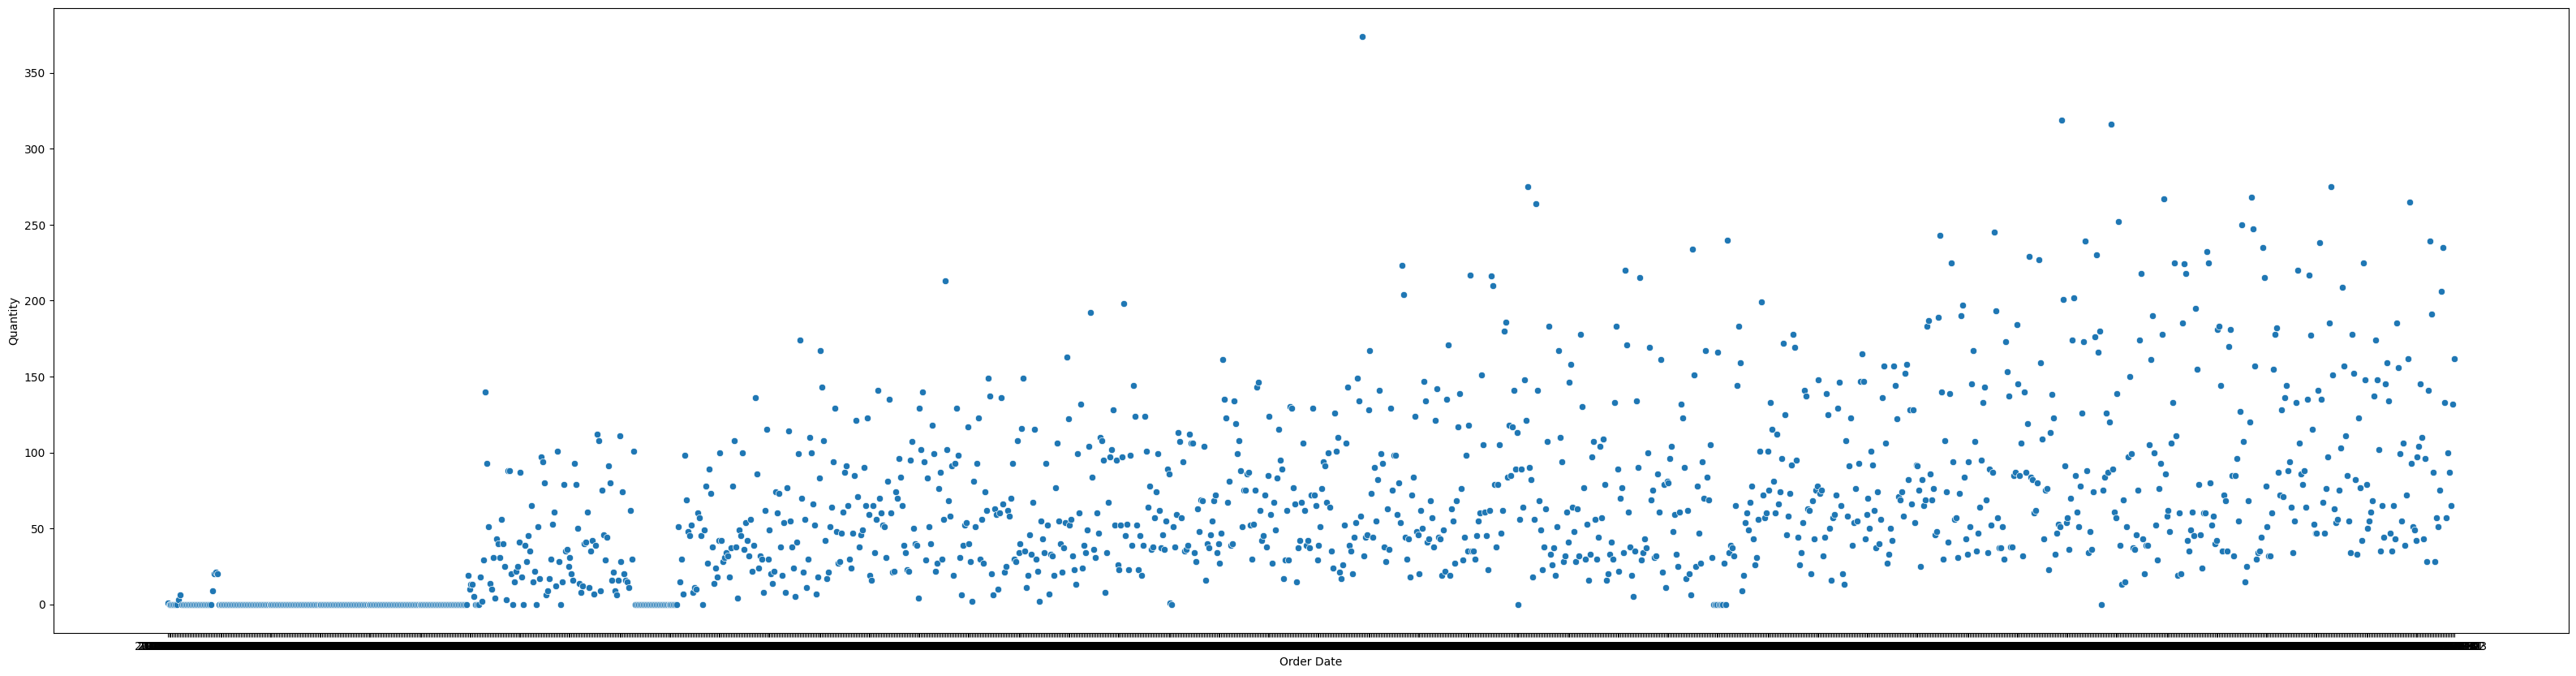

In [27]:
# X axis for plot
x_axis = pd.date_range(start='2015-09-01', end='2019-08-03')

# Y axis - count of order
plt.figure(figsize=(40, 10))
sns.scatterplot(x = orders_quantity_by_date['Order Date'], y = orders_quantity_by_date['Quantity'])
plt.xticks(x_axis)
plt.plot()

In [28]:
# Let make the histogram to see the distribution order of each year.
# Add the column Year and Month
orders['Year'] = orders['Order Date'].dt.year
orders['Month'] = orders['Order Date'].dt.month

# Return Month/Year data frame
month_year_df = orders.groupby(['Year', 'Month'])['Quantity'].sum().reset_index()
month_year_df

,Year,Month,Quantity
0,2015,9,39
1,2015,10,41
2,2016,3,690
3,2016,4,1168
4,2016,5,1280
5,2016,6,780
6,2016,7,606
7,2016,8,1416
8,2016,9,1468
9,2016,10,2088


C:\Users\famsu\AppData\Local\Temp\ipykernel_22884\4286553664.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Month')['Quantity'].sum().reset_index()
C:\Users\famsu\AppData\Local\Temp\ipykernel_22884\4286553664.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Month')['Quantity'].sum().reset_index()
C:\Users\famsu\AppData\Local\Temp\ipykernel_22884\4286553664.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt t

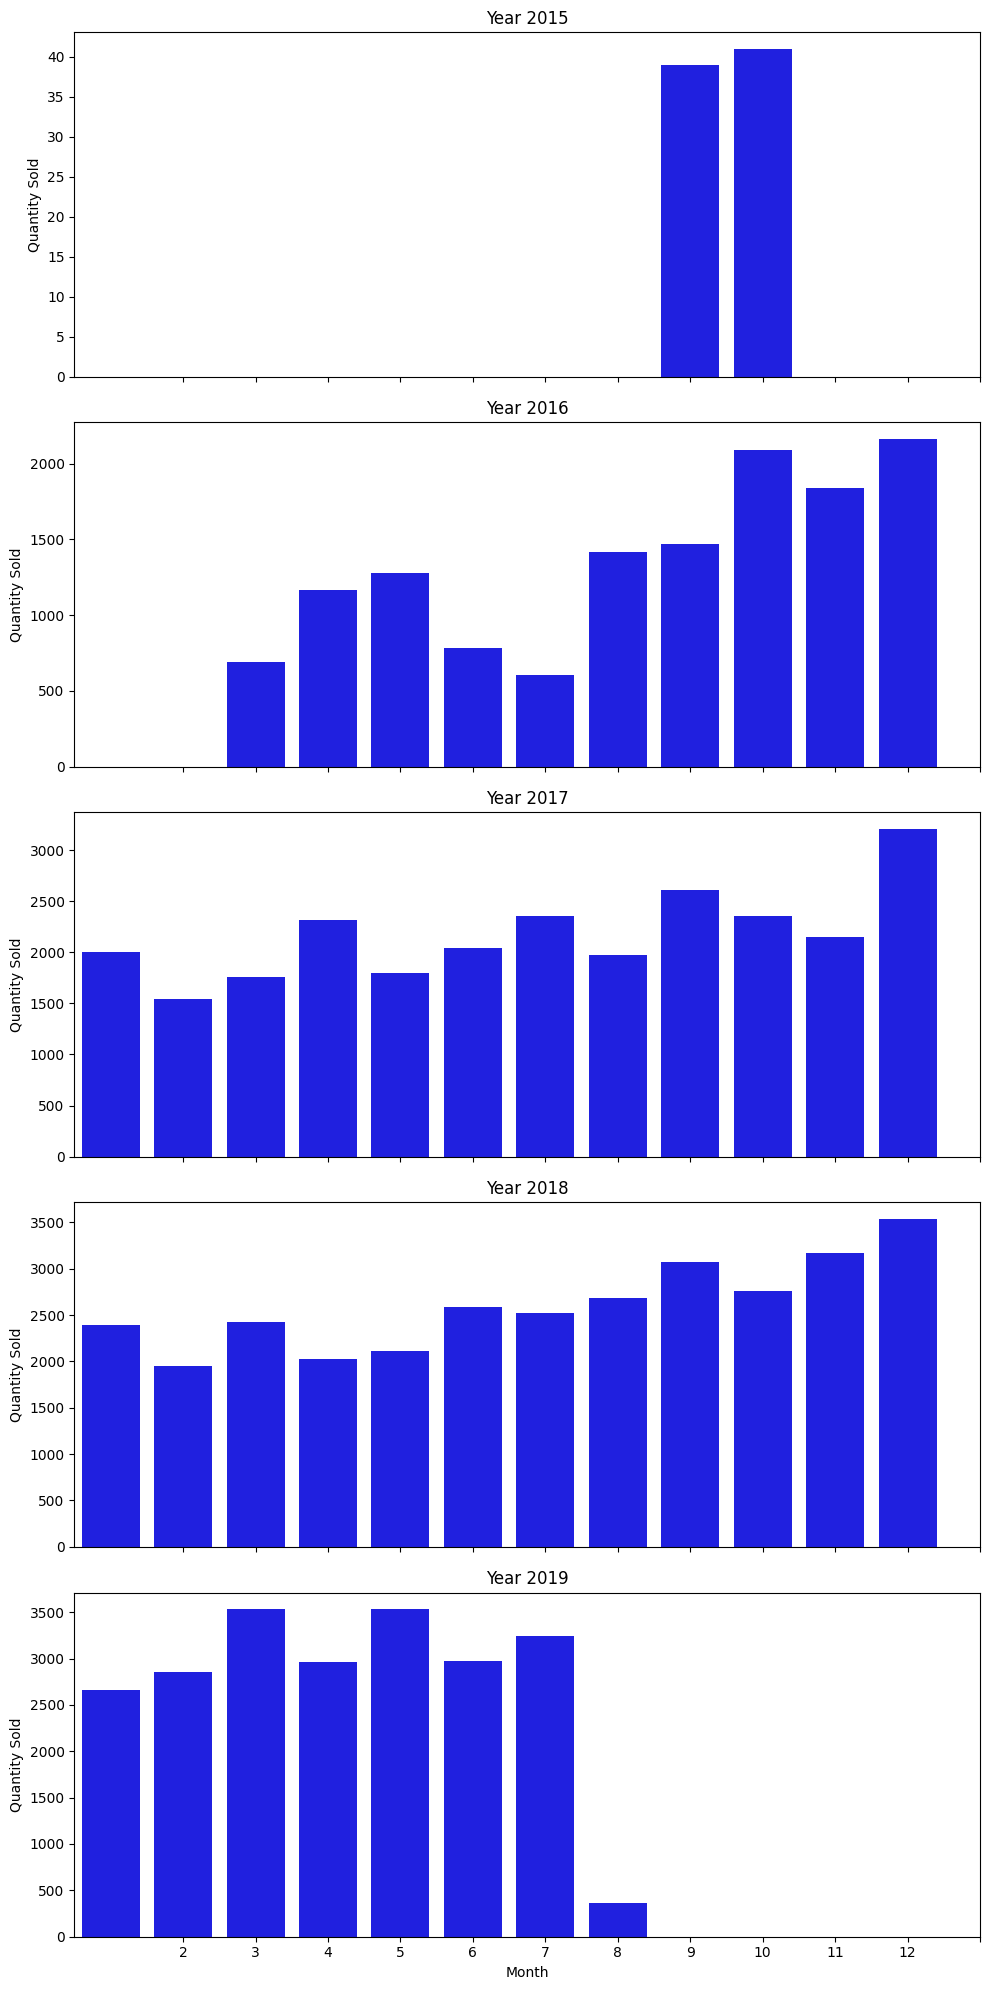

In [36]:
# Visualize the distribution
month_year_df['Month'] = pd.Categorical(
    month_year_df['Month'], categories=range(1, 13), ordered=True
)
years = month_year_df['Year'].unique()
num_years = len(years)
fig, axes = plt.subplots(nrows=num_years, ncols=1, figsize=(10, num_years * 4), sharex=True)
bin_edges = np.linspace(0.5, 12.5, 13)
for i, year in enumerate(years):
    ax = axes[i]
    data = month_year_df[month_year_df['Year'] == year]
    # sns.histplot(data, x='Month', weights='Quantity', bins=12, kde=True, ax=ax, color='skyblue')
    # Use the histoplot to visualisation the distribution. Got the issue with display the histogram. Some bars are thin or thick
    # The visualization show the 
    # ax.bar(data['Month'], data['Quantity'], color='skyblue')
    grouped = data.groupby('Month')['Quantity'].sum().reset_index()
    sns.barplot(data=grouped, x='Month', y='Quantity', ax=ax, color='blue')

    ax.set_title(f"Year {year}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Quantity Sold")
    ax.set_xticks(range(1, 13))  # Ensure months are labeled correctly

plt.tight_layout()
plt.show()

C:\Users\famsu\AppData\Local\Temp\ipykernel_22884\3015224478.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = month_year_df.groupby(['Year', 'Month'])['Quantity'].sum().reset_index()


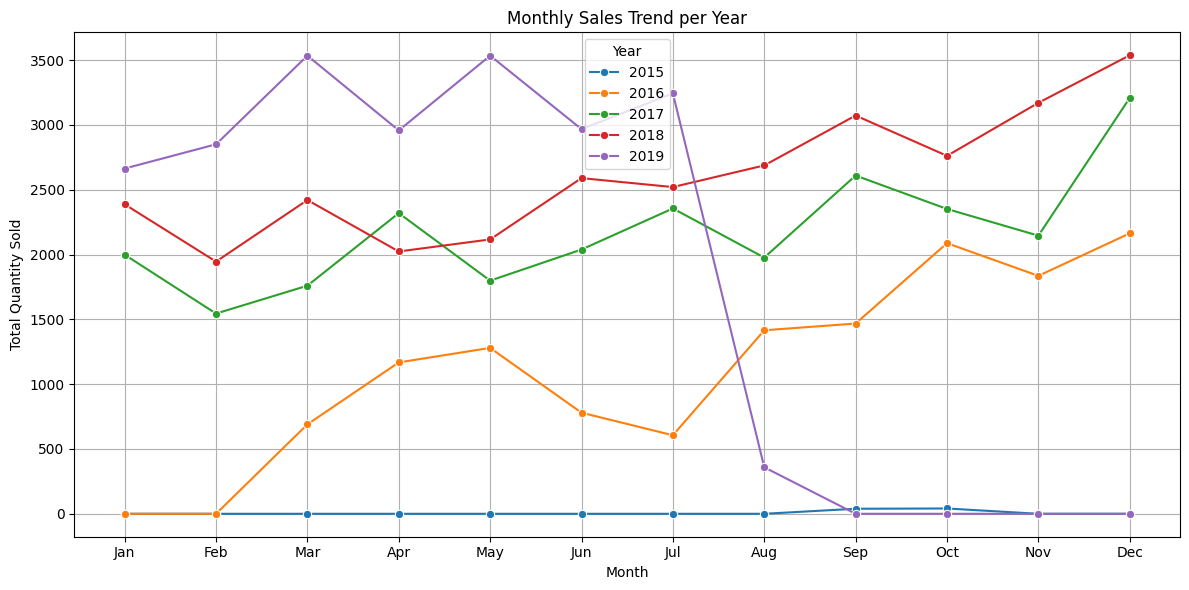

In [39]:
# Visualize the seasonality
grouped = month_year_df.groupby(['Year', 'Month'])['Quantity'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='Month', y='Quantity', hue='Year', marker='o', palette='tab10')

plt.title("Monthly Sales Trend per Year")
plt.xlabel("Month")
plt.ylabel("Total Quantity Sold")
plt.xticks(ticks=range(1, 13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.grid(True)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

C:\Users\famsu\AppData\Local\Temp\ipykernel_22884\4131213867.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_year_df.groupby('Month')['Quantity'].mean().plot(kind='bar')


<Axes: xlabel='Month'>

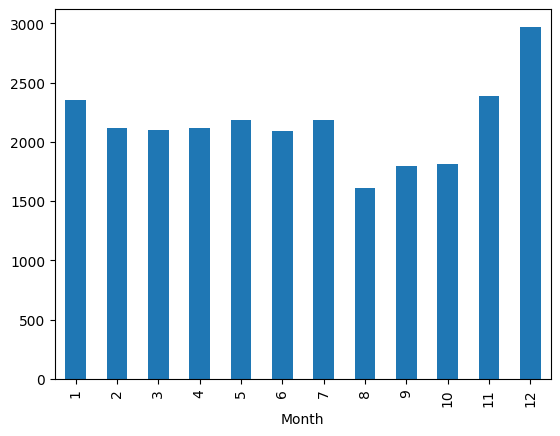

In [41]:
# Show the most sold month by avg
month_year_df.groupby('Month')['Quantity'].mean().plot(kind='bar')

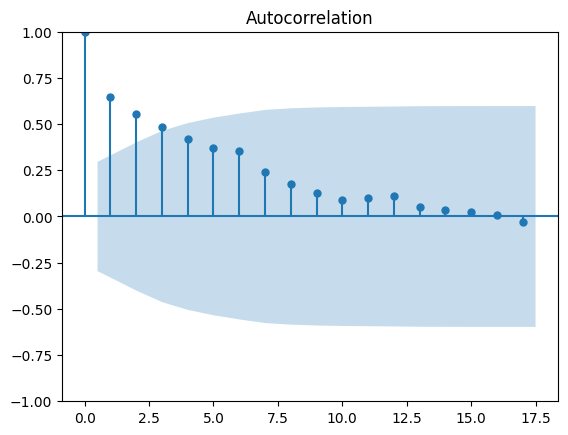

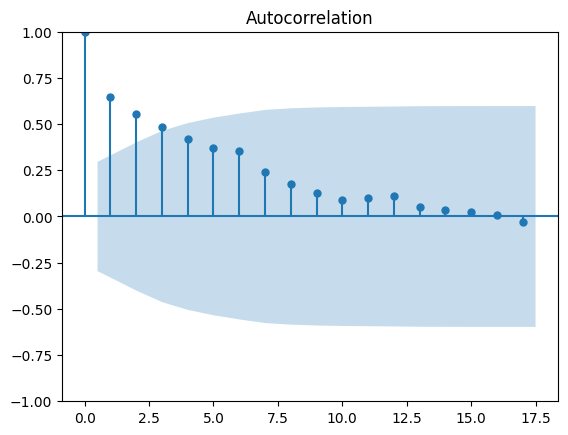

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(month_year_df['Quantity'])  # or df.set_index('Date')['Quantity']
